# Running `ImageComparison` on seal impressions
*By Andreas Angourakis (08/06/2021)*

This Jupyter notebook can be run if placed in the root directory of https://github.com/maltaweel/ImageComparison and a directory named "input_seals" is added with the corresponding images.

## Walkthrough or step-by-step demonstration
### Import modules

In [1]:
import argparse
import sys
import os
from os import listdir
from os.path import isfile, join
from typing import Dict, List, Optional, Tuple
import time

import imagehash
import numpy as np
from PIL import Image
import csv
from src.lsh.imageFileDataLoader import ImageFile

In [33]:
import matplotlib as mplt
import matplotlib.pyplot as plt

### Define and set global parameters

In [3]:
# input folder
inputDirectory = 'input_seals/'
# similarity threshold
threshold = 0.5
# hash size to use, signature length = hash_size^2
hashSize = 16
# number of bands
bands = 16

NOTE: the default threshold value of 0.9 seems to high to identify any pairs of "near_duplicates"

### Define and demonstrate `calculate_signature()`

In [4]:
"""
    Calculate the dhash signature of a given file using dhash technique.
    
    
    @param image_file: the image (path as string) to calculate the signature for
    @param hash_size: hash size to use, signatures will be of length hash_size^2
    
    @return :Image signature as Numpy n-dimensional array or None if the file is not a PIL recognized image
"""
def calculate_signature(image_file: str, hash_size: int) -> np.ndarray:
   
    try:
        pil_image = Image.open(image_file).convert("L").resize(
                            (hash_size+1, hash_size), 
                            Image.ANTIALIAS)
        dhash = imagehash.dhash(pil_image, hash_size)
        signature = dhash.hash.flatten()
        pil_image.close()
        return signature
    except IOError as e:
        raise e

Run it with "achaemenid_1.jpg":

In [5]:
imageSignature = calculate_signature(inputDirectory + "Alalah_S002058(d).jpg", 16)

We can visualise the signature of an image in two ways:

- terminal output (Boolean array)

In [6]:
imageSignature

array([False,  True, False, False,  True, False,  True, False, False,
       False, False,  True, False, False, False,  True, False,  True,
        True, False, False,  True,  True, False,  True, False, False,
       False,  True, False, False,  True, False,  True,  True, False,
        True, False,  True,  True, False,  True, False, False,  True,
        True, False,  True, False, False,  True,  True, False, False,
        True,  True, False,  True, False, False, False,  True, False,
       False, False, False,  True,  True, False, False,  True, False,
       False,  True,  True, False,  True,  True, False, False, False,
        True,  True,  True, False, False,  True, False,  True, False,
       False,  True, False,  True, False,  True, False, False,  True,
        True, False, False,  True, False,  True, False,  True,  True,
       False,  True,  True,  True, False, False,  True,  True, False,
        True, False, False,  True, False,  True,  True, False,  True,
        True,  True,

- Barcode plot

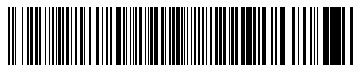

In [7]:
barprops = dict(aspect='auto', cmap='binary', interpolation='nearest')

fig = plt.figure()

ax2 = fig.add_axes([0.3, 0.4, 0.8, 0.2])
ax2.set_axis_off()
ax2.imshow(imageSignature.reshape((1, -1)), **barprops)

plt.show()


Visually compare it with "achaemenid2.jpg" signature

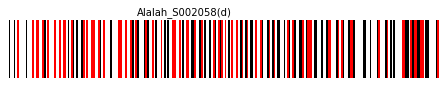

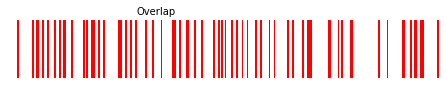

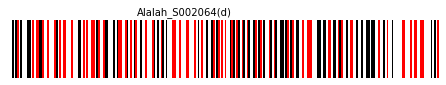

In [50]:
anotherImageSignature = calculate_signature(inputDirectory + "Alalah_S002064(d).jpg", 16)

overlapOfSignatures = np.logical_and(imageSignature, anotherImageSignature)
cmapOverlap = mplt.colors.ListedColormap([(0, 0, 0, 0), (1, 0, 0, 1)])

fig = plt.figure()

ax2 = fig.add_axes([0, 0.1, 1, 0.2])
ax2.set_axis_off()
fig.text(.3, 0.32, 'Alalah_S002058(d)')

ax2.imshow(imageSignature.reshape((1, -1)), **barprops)
ax2.imshow(overlapOfSignatures.reshape((1, -1)), aspect='auto', cmap=cmapOverlap, interpolation='nearest')

fig = plt.figure()

ax2 = fig.add_axes([0, 0.1, 1, 0.2])
ax2.set_axis_off()
fig.text(.3, 0.32, 'Overlap')

ax2.imshow(overlapOfSignatures.reshape((1, -1)), aspect='auto', cmap=cmapOverlap, interpolation='nearest')

fig = plt.figure()

ax2 = fig.add_axes([0, 0.1, 1, 0.2])
ax2.set_axis_off()
fig.text(.3, 0.32, 'Alalah_S002064(d)')

ax2.imshow(anotherImageSignature.reshape((1, -1)), **barprops)
ax2.imshow(overlapOfSignatures.reshape((1, -1)), aspect='auto', cmap=cmapOverlap, interpolation='nearest')

plt.show()


Use fragment of code from `find_near_duplicates()` (lines 114-118) to get a similarity score comparing "achaemenid_1.jpg" and "achaemenid2.jpg":

In [17]:
hashDifference = sum(
    np.bitwise_xor(
        np.unpackbits(np.packbits(imageSignature)), 
        np.unpackbits(np.packbits(anotherImageSignature))
    )    
)
similarity = (hashSize**2 - hashDifference) / hashSize**2

print("hashDifference = " + str(hashDifference) + ", Similarity score = " + str(similarity))

hashDifference = 124, Similarity score = 0.515625


In sake of testing, we can run comparisons between two identical signatures, which should return "hashDifference = 0 and similarity = 1.0":

In [18]:
hashDifference = sum(
    np.bitwise_xor(
        np.unpackbits(np.packbits(imageSignature)), 
        np.unpackbits(np.packbits(imageSignature)) # <- changed
    )    
)
similarity = (hashSize**2 - hashDifference) / hashSize**2

print("hashDifference = " + str(hashDifference) + ", Similarity score = " + str(similarity))

hashDifference = 0, Similarity score = 1.0


### Define and demonstrate `find_near_duplicates()`

In [19]:
'''
    Find near-duplicate images
    
    
    @param: input_dir: Directory with images to check
    @param: threshold: Images with a similarity ratio >= threshold will be considered near-duplicates
    @param: hash_size: Hash size to use, signatures will be of length hash_size^2
    @param bands: The number of bands to use in the locality sensitve hashing process
        
    @return: A list of near-duplicates found. Near duplicates are encoded as a triple: (filename_A, filename_B, similarity)
'''  
def find_near_duplicates(input_dir: str, threshold: float, hash_size: int, bands: int) -> List[Tuple[str, str, float]]:
   
    #int
    rows  = int(hash_size**2/bands)
    
    signatures = dict()
    
    #:  List[Dict[str, List[str]]]
    
    hash_buckets_list = [dict() for _ in range(bands)]
    
    # Build a list of candidate files in given input_dir
    try:
        file_list = [join(input_dir, f) for f in listdir(input_dir) if isfile(join(input_dir, f))]
    except OSError as e:
        raise e
    
    # Iterate through all files in input directory
    for fh in file_list:
        try:
            signature = calculate_signature(fh, hash_size)
        except IOError:
            # Not a PIL image, skip this file
            continue

        # Keep track of each image's signature
        signatures[fh] = np.packbits(signature)
        
        # Locality Sensitive Hashing
        for i in range(bands):
            signature_band = signature[i*rows:(i+1)*rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in hash_buckets_list[i]:
                hash_buckets_list[i][signature_band_bytes] = list()
            hash_buckets_list[i][signature_band_bytes].append(fh)

    # Build candidate pairs based on bucket membership
    candidate_pairs = set()
    for hash_buckets in hash_buckets_list:
        for hash_bucket in hash_buckets.values():
            if len(hash_bucket) > 1:
                hash_bucket = sorted(hash_bucket)
                for i in range(len(hash_bucket)):
                    for j in range(i+1, len(hash_bucket)):
                        candidate_pairs.add(
                            tuple([hash_bucket[i],hash_bucket[j]])
                        )

    # Check candidate pairs for similarity
    near_duplicates = list()
    for cpa, cpb in candidate_pairs:
        hd = sum(np.bitwise_xor(
                np.unpackbits(signatures[cpa]), 
                np.unpackbits(signatures[cpb])
        ))
        similarity = (hash_size**2 - hd) / hash_size**2
       
        if similarity > threshold:
            near_duplicates.append((cpa, cpb, similarity))
        else:
            print(similarity)
            near_duplicates.append((cpa, cpb, 0.0))
            
    # Sort near-duplicates by descending similarity and return
    near_duplicates.sort(key=lambda x:x[2], reverse=True)
    return near_duplicates


In [20]:
listOfNearDuplicates = find_near_duplicates(input_dir=inputDirectory, threshold=threshold, hash_size=hashSize, bands=bands)
# it will print out any similarity values that are < threshold

0.4765625
0.49609375
0.49609375
0.48046875
0.4921875
0.5
0.48046875
0.5
0.49609375
0.45703125
0.4921875
0.5


Print the result as a table:

Define the function `print_similarity_score_table()`:

In [21]:
def print_similarity_score_table(listOfPairsWithScore):
    element_in_tuple = len(listOfPairsWithScore[0])
    max_length_column = []

    for i in range(element_in_tuple):
        max_length_column.append(max(len(str(e[i]))+2 for e in listOfPairsWithScore))

    # header
    headerTitles = ["image #1", "image #2", "Similarity score"]
    for i in range(element_in_tuple):
        print(headerTitles[i].ljust(max_length_column[i]), end='')
    print()
    # line
    print("-" * sum(max_length_column))
    # body
    for e in listOfPairsWithScore:
        for i in range(element_in_tuple):
            print(str(e[i]).ljust(max_length_column[i]), end='')
        print()

In [22]:
print_similarity_score_table(listOfNearDuplicates)

     0.59765625  
input_seals/Failaka_S001979.jpg           input_seals/salje.tafel 1.4.d.jpg         0.59765625  
input_seals/salje.tafel 1.14.d.jpg        input_seals/salje.tafel 9.171.d.jpg       0.59765625  
input_seals/Ugarit_S002341(d).jpg         input_seals/salje.tafel 1.15.d.jpg        0.59765625  
input_seals/salje.tafel 14.287(67).d.jpg  input_seals/salje.tafel 2.34.d.jpg        0.59765625  
input_seals/salje.tafel 1.3d.jpg          input_seals/salje.tafel 9.172.d.jpg       0.59765625  
input_seals/salje.tafel 6.100.d.jpg       input_seals/salje.tafel 7.125.d.jpg       0.59765625  
input_seals/salje.tafel 11.208.d.jpg      input_seals/salje.tafel 6.101.d.jpg       0.59765625  
input_seals/Salje.tafel 7.122.d.jpg       input_seals/salje.tafel 11.204.d.jpg      0.59765625  
input_seals/Salje.tafel 7.122.d.jpg       input_seals/salje.tafel 9.173.d.jpg       0.59375     
input_seals/salje.tafel 12.215.d.jpg      input_seals/salje.tafel 5.92.d.jpg        0.59375     
input_seals/

Plot similarity score in histogram:

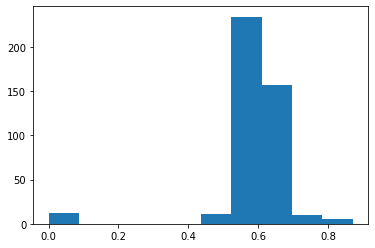

In [14]:
similarityScores = [x[2] for x in listOfNearDuplicates]
plt.hist(similarityScores)
plt.show() 

In [ ]:
Define `plot_image_pairs_with_similarity()`:

In [25]:
def plot_image_pairs_with_similarity(imagePairsWithSimilarity, fontsize_imageName = 10, fontsize_similarity = 14, figsize_per_row = (10, 2)):
    # prepare plotting matrix
    ncols = 3
    nrows = len(imagePairsWithSimilarity)

    plt.rcParams["figure.figsize"] = (figsize_per_row[0], nrows * figsize_per_row[1])
    fig,ax = plt.subplots(nrows = nrows, ncols = ncols)

    # print images
    for i in range(nrows):
        for j in range(ncols):
            if (j == 2):
                ax[i][j].axis([0, 10, 0, 10])
                ax[i][j].text(2, 6, imagePairsWithSimilarity[i][j], fontsize = fontsize_similarity)
            else:
                ax[i][j].set_title(imagePairsWithSimilarity[i][j].removeprefix(inputDirectory).removesuffix('.jpg'), fontsize = fontsize_imageName)
                with open(imagePairsWithSimilarity[i][j], 'rb') as f:
                    image = Image.open(f)
                    ax[i][j].imshow(image)
            ax[i][j].set_axis_off()
    fig.show()

In [ ]:
Display images with the five highest similarity scores:

In [27]:
bestSimilarityPairs = tuple(sorted(listOfNearDuplicates, key=lambda item: item[2], reverse=True))[:5]
bestSimilarityPairs

(('input_seals/Salje.tafel 3.44.d.jpg',
  'input_seals/salje.tafel 9.180.d.jpg',
  0.87109375),
 ('input_seals/salje.tafel 11.204.d.jpg',
  'input_seals/salje.tafel 5.90.d.jpg',
  0.83984375),
 ('input_seals/salje.tafel 14.282.d.jpg',
  'input_seals/salje.tafel 3.41.d.jpg',
  0.82421875),
 ('input_seals/salje.tafel 14.284.d.jpg',
  'input_seals/salje.tafel 6.99.d.jpg',
  0.80859375),
 ('input_seals/salje.tafel 10.182.d.jpg',
  'input_seals/salje.tafel 14.285.d.jpg',
  0.7890625))

<ipython-input-25-e96eaa444e6a>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


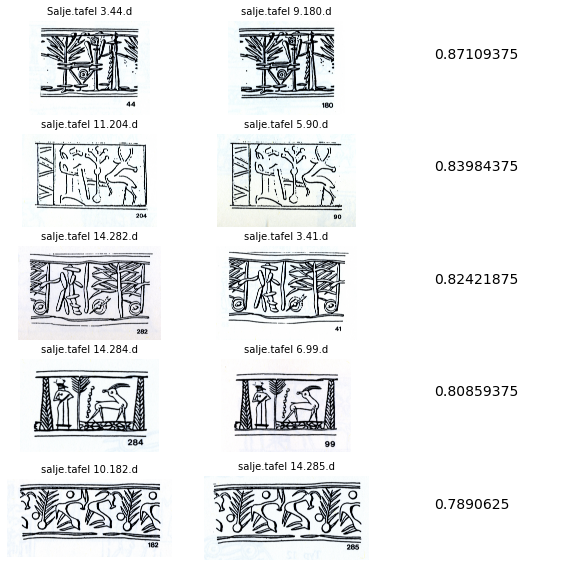

In [28]:
plot_image_pairs_with_similarity(bestSimilarityPairs)

Display images with the five least non-zero similarity scores:

In [32]:
worseNonZeroSimilarityPairs = tuple(sorted([x for x in listOfNearDuplicates if x[2] > 0], key=lambda item: item[2], reverse=False))[:5]
worseNonZeroSimilarityPairs

(('input_seals/salje.tafel 13.241.d.jpg',
  'input_seals/salje.tafel 5.92.d.jpg',
  0.5078125),
 ('input_seals/Ugarit_S002223(d).jpg',
  'input_seals/salje.tafel 1.4.d.jpg',
  0.51171875),
 ('input_seals/Ugarit_S002223(d).jpg',
  'input_seals/salje.tafel 11.199.d.jpg',
  0.51171875),
 ('input_seals/salje.tafel 6.104.d.jpg',
  'input_seals/salje.tafel 9.171.d.jpg',
  0.51171875),
 ('input_seals/Failaka_S001979.jpg',
  'input_seals/Ugarit_S002223(d).jpg',
  0.515625))

<ipython-input-25-e96eaa444e6a>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


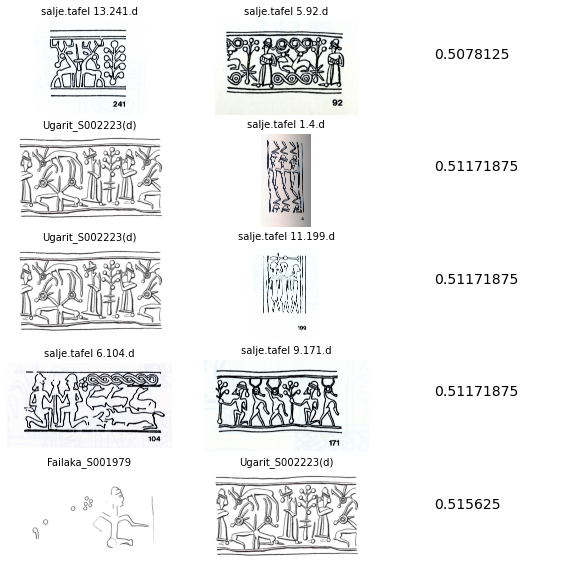

In [33]:
plot_image_pairs_with_similarity(worseNonZeroSimilarityPairs)

Display images with zero similarity score between them:

In [29]:
# get list of file names involved in a zero similarity comparison
zeroSimilarityPairs = [x for x in listOfNearDuplicates if x[2] == 0]
zeroSimilarityPairs

[('input_seals/Failaka_S002500.jpg',
  'input_seals/salje.tafel 2.37.d.jpg',
  0.0),
 ('input_seals/Ugarit_S002183(d).jpg',
  'input_seals/salje.tafel 11.199.d.jpg',
  0.0),
 ('input_seals/salje.tafel 13.241.d.jpg',
  'input_seals/salje.tafel 6.110.d.jpg',
  0.0),
 ('input_seals/salje.tafel 5.79.d.jpg',
  'input_seals/salje.tafel 7.126.d.jpg',
  0.0),
 ('input_seals/salje.tafel 1.12.d.jpg',
  'input_seals/salje.tafel 6.108.d.jpg',
  0.0),
 ('input_seals/salje.tafel 11.199.d.jpg',
  'input_seals/salje.tafel 5.92.d.jpg',
  0.0),
 ('input_seals/salje.tafel 13.241.d.jpg',
  'input_seals/salje.tafel 6.100.d.jpg',
  0.0),
 ('input_seals/Salje.tafel 4.65.d.jpg',
  'input_seals/salje.tafel 9.172.d.jpg',
  0.0),
 ('input_seals/Alalah_S002091(d).jpg',
  'input_seals/salje.tafel 13.246.d.jpg',
  0.0),
 ('input_seals/salje.tafel 11.199.d.jpg',
  'input_seals/salje.tafel 6.100.d.jpg',
  0.0),
 ('input_seals/salje.tafel 11.199.d.jpg',
  'input_seals/salje.tafel 12.215.d.jpg',
  0.0),
 ('input_seals/

<ipython-input-25-e96eaa444e6a>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


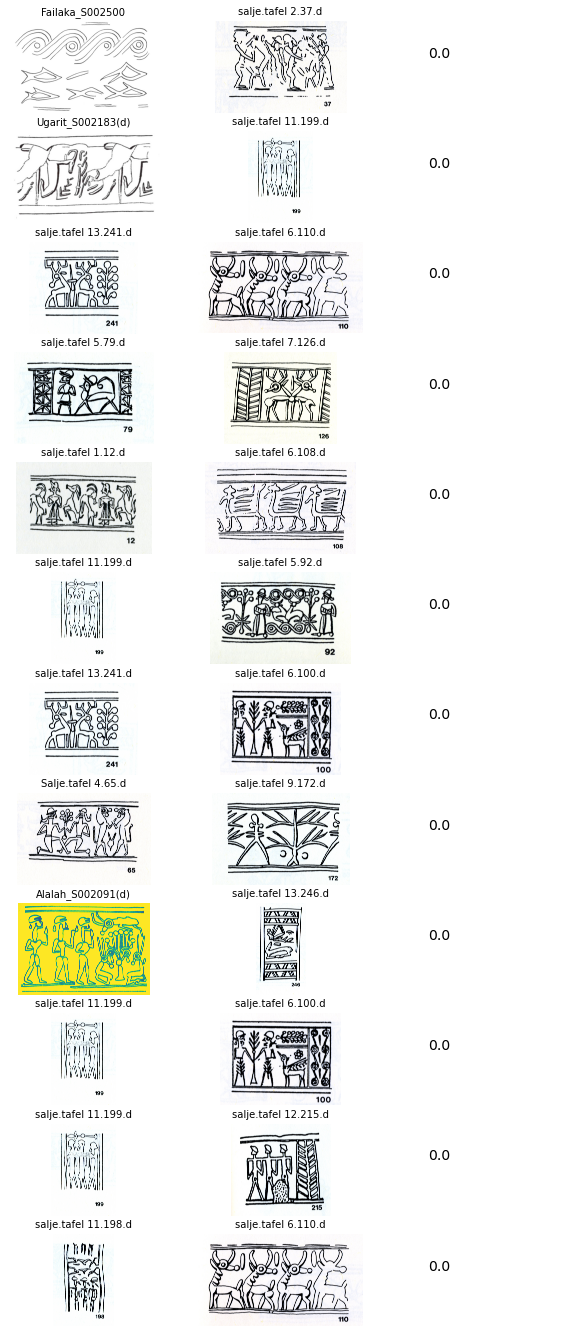

In [30]:
plot_image_pairs_with_similarity(zeroSimilarityPairs)


Save notebook in HTML format:

In [ ]:
!jupyter nbconvert --to html RunOnSeals.ipynb